In [18]:
from pydub import AudioSegment
from scipy import fftpack
from scipy import signal


import wave
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [19]:
AUDIO = "motive.wav"

## Key Data

In [20]:
audio_segment = AudioSegment.from_file(AUDIO)

ch = audio_segment.channels
sw = audio_segment.sample_width
fr = audio_segment.frame_rate
fw = audio_segment.frame_width
ms = len(audio_segment)
fc = int(audio_segment.frame_count())
it = audio_segment.dBFS

print(f"Channels: {ch}")
print(f"Sample width: {sw}")
print(f"Frame rate (sample rate): {fr}")
print(f"Frame width: {fw}")
print(f"Length (ms): {ms}")
print(f"Frame count: {fc}")
print(f"Intensity: {it}")

Channels: 2
Sample width: 2
Frame rate (sample rate): 48000
Frame width: 4
Length (ms): 123312
Frame count: 5918981
Intensity: -9.435466987140009


## Sound wave

TypeError: 'AxesSubplot' object does not support item assignment

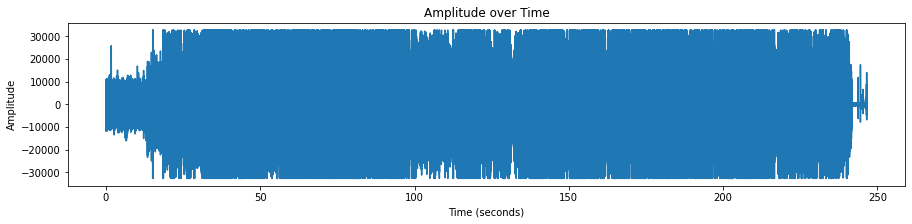

In [21]:
sf_filewave = wave.open(AUDIO,"r")
signal_sf = sf_filewave.readframes(-1)

# Convert audio bytes to integers
soundwave_sf = np.frombuffer(signal_sf, dtype='int16')
time_sf = np.linspace(start=0,
                      stop=fc*sw/fr,
                      num=fc*sw)

f, ax = plt.subplots(figsize=(15, 3))

plt.title('Amplitude over Time')
plt.ylabel('Amplitude')
plt.xlabel('Time (seconds)')
ax[0] = plt.plot(time_sf, soundwave_sf)
plt.legend()
plt.show()

## Spectrogram

In [ ]:
x, sr = librosa.load(AUDIO)
# Spectrogram of frequency
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(15, 3))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

## RMS

[Text(0.5, 1.0, 'log Power spectrogram')]

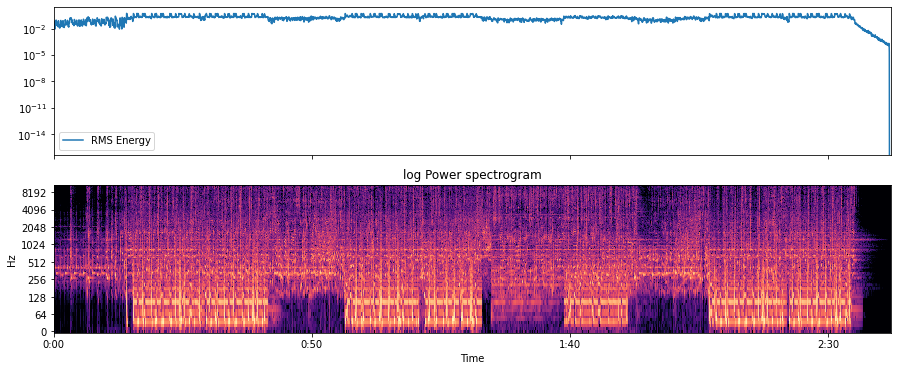

In [6]:
S, phase = librosa.magphase(librosa.stft(x))
rms = librosa.feature.rms(S=S)
# Plot the RMS energy
fig, ax = plt.subplots(figsize=(15, 6), nrows=2, sharex=True)
times = librosa.times_like(rms)
ax[0].semilogy(times, rms[0], label='RMS Energy')
ax[0].set(xticks=[])
ax[0].legend()
ax[0].label_outer()
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis='log', x_axis='time', ax=ax[1])
ax[1].set(title='log Power spectrogram')

## ZCR

Zero crossing rate: 342404


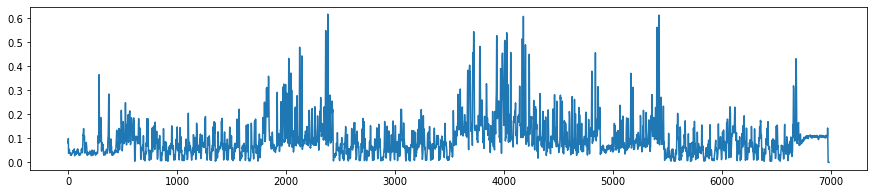

In [7]:
zcrs = librosa.feature.zero_crossing_rate(x)
print(f"Zero crossing rate: {sum(librosa.zero_crossings(x))}")
plt.figure(figsize=(15, 3))
plt.plot(zcrs[0])

## MFCCs

C:\Users\Oliver\AppData\Local\Temp\ipykernel_18756\3628311085.py:1: FutureWarning: Pass y=[-2.8357244e-05  8.0354312e-08  5.3743774e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(x, sr=sr)


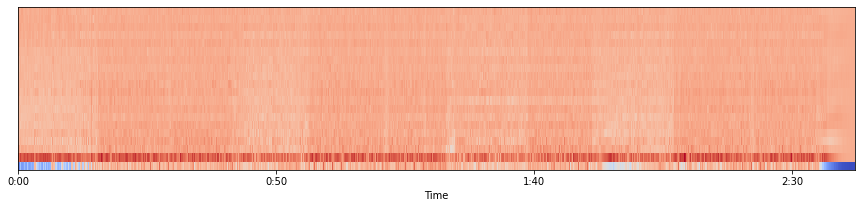

In [8]:
mfccs = librosa.feature.mfcc(x, sr=sr)
# Displaying  the MFCCs:
plt.figure(figsize=(15, 3))
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

## Chroma

C:\Users\Oliver\AppData\Local\Temp\ipykernel_18756\2720203770.py:2: FutureWarning: Pass y=[-2.8357244e-05  8.0354312e-08  5.3743774e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  chromagram = librosa.feature.chroma_stft(x, sr=sr, hop_length=hop_length)


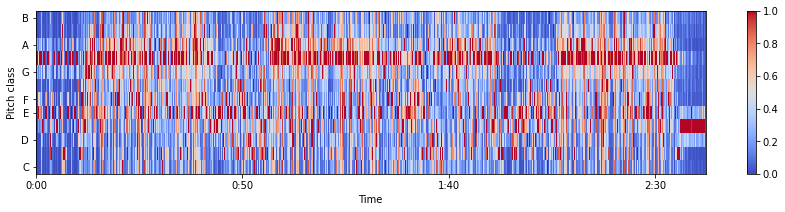

In [9]:
hop_length = 512
chromagram = librosa.feature.chroma_stft(x, sr=sr, hop_length=hop_length)
fig, ax = plt.subplots(figsize=(15, 3))
img = librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')
fig.colorbar(img, ax=ax)

## Tempogram

In [10]:
oenv = librosa.onset.onset_strength(y=x, sr=sr, hop_length=hop_length)
tempogram = librosa.feature.tempogram(onset_envelope=oenv, sr=sr,
                                      hop_length=hop_length)
# Compute global onset autocorrelation
ac_global = librosa.autocorrelate(oenv, max_size=tempogram.shape[0])
ac_global = librosa.util.normalize(ac_global)
# Estimate the global tempo for display purposes
tempo = librosa.beat.tempo(onset_envelope=oenv, sr=sr,
                           hop_length=hop_length)[0]

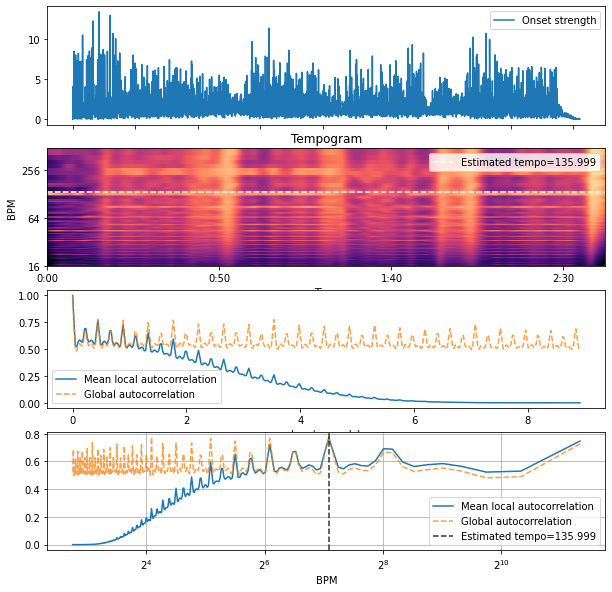

In [11]:
fig, ax = plt.subplots(nrows=4, figsize=(10, 10))
times = librosa.times_like(oenv, sr=sr, hop_length=hop_length)
ax[0].plot(times, oenv, label='Onset strength')
ax[0].label_outer()
ax[0].legend(frameon=True)
librosa.display.specshow(tempogram, sr=sr, hop_length=hop_length,
                         x_axis='time', y_axis='tempo', cmap='magma',
                         ax=ax[1])
ax[1].axhline(tempo, color='w', linestyle='--', alpha=1,
            label='Estimated tempo={:g}'.format(tempo))
ax[1].legend(loc='upper right')
ax[1].set(title='Tempogram')
x = np.linspace(0, tempogram.shape[0] * float(hop_length) / sr,
                num=tempogram.shape[0])
ax[2].plot(x, np.mean(tempogram, axis=1), label='Mean local autocorrelation')
ax[2].plot(x, ac_global, '--', alpha=0.75, label='Global autocorrelation')
ax[2].set(xlabel='Lag (seconds)')
ax[2].legend(frameon=True)
freqs = librosa.tempo_frequencies(tempogram.shape[0], hop_length=hop_length, sr=sr)
ax[3].semilogx(freqs[1:], np.mean(tempogram[1:], axis=1),
             label='Mean local autocorrelation', base=2)
ax[3].semilogx(freqs[1:], ac_global[1:], '--', alpha=0.75,
             label='Global autocorrelation', base=2)
ax[3].axvline(tempo, color='black', linestyle='--', alpha=.8,
            label='Estimated tempo={:g}'.format(tempo))
ax[3].legend(frameon=True)
ax[3].set(xlabel='BPM')
ax[3].grid(True)

In [12]:
print(f"soundwave: {soundwave_sf.shape}")
print(f"Xdb: {Xdb.shape}, min:({Xdb.min()})")
print(f"RMS: {rms.shape}, min:({rms.min()})")
print(f"ZCR: {zcrs.shape}, min:({zcrs.min()})")
print(f"MFCCs: {mfccs.shape}, min:({mfccs.min()})")
print(f"Chrome: {chromagram.shape}, min:({chromagram.min()})")
print(f"Tempogram: {tempogram.shape}, min:({tempogram.min()})")
print(f"Onset Autocorrelatiof: {ac_global.shape}")
print(f"Tempo: {tempo}")
len(soundwave_sf)



soundwave: (15567030,)
Xdb: (1025, 6984), min:(-25.609966278076172)
RMS: (1, 6984), min:(0.0)
ZCR: (1, 6984), min:(0.0)
MFCCs: (20, 6984), min:(-437.1826171875)
Chrome: (12, 6984), min:(0.0)
Tempogram: (384, 6984), min:(-4.665719444477829e-16)
Onset Autocorrelatiof: (384,)
Tempo: 135.99917763157896


15567030

## Normalize + Shrink + Save

In [13]:
def norm(arr):
    return ((arr - np.min(arr))/np.ptp(arr)).astype(np.float16)


def shrink(arr):
    #gaussian blur kernel
    t = np.linspace(-10, 10, 30)
    bump = np.exp(-0.1*t**2)
    bump /= np.trapz(bump)
    kernel = bump[:, np.newaxis] * bump[np.newaxis, :]
    return signal.fftconvolve(arr, kernel, mode='same')
vls = [Xdb,rms,zcrs,mfccs,chromagram,tempogram]

In [14]:
FD =[]
for a in vls:
    a = norm(a)
    FD = a if len(FD) == 0 else np.concatenate((FD,a),0)
FD = shrink(FD)

In [15]:
shape = FD.shape
FD = np.reshape(FD,[shape[1],shape[0]])
FD.shape

(6984, 1443)

In [17]:
pd.DataFrame(FD).to_csv(f"{AUDIO}_{FD.shape[0]}_{FD.shape[1]}.csv",header=False, index=False)